In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import keras
from keras import models
from keras import layers
import tensorflow as tf
from keras.backend import binary_crossentropy
from keras import backend as K
from keras.callbacks import Callback
from keras import optimizers
from keras.backend import mean
from keras import regularizers
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.clear_session()

W1008 19:47:45.168292 140657131022144 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W1008 19:47:45.169159 140657131022144 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1008 19:47:45.172429 140657131022144 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



# Reading Data

In [3]:
path = '/home/ricardo/TCC/'

In [4]:
df = pd.read_csv(path+'train.csv', sep = ',')
X = df.loc[:,'var_0':'var_199']
Y = df.loc[:,'target']

In [5]:
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


# Normalazing Data

In [6]:
meanX = X.mean(axis = 0)
stdX = X.std(axis = 0)
X_norm = (X-meanX)/stdX

# Separating the Data in anomaly and not anomaly

In [7]:
fraud_index = np.where(Y==1)
honest_index = np.where(Y==0)
fraud = X_norm.loc[fraud_index]
honest = X_norm.loc[honest_index]

yh = Y.loc[honest_index]
yf = Y.loc[fraud_index]

# Balanced Data

### Verifying how unbalanced is our dataset

Text(0.5, 1.0, '8.951238929246692')

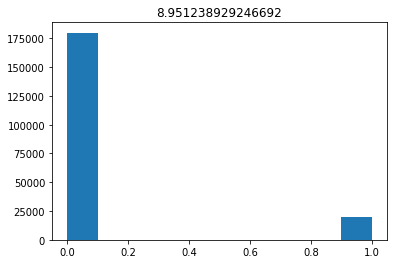

In [8]:
plt.hist(Y)
plt.title(len(yh)/len(yf))

### To balance the data we will eliminate some not anomaly samples

In [9]:
h_used, x_trash, yh, y_trash = train_test_split(honest, yh, test_size = 0.75, random_state = 30)
x_used = pd.concat([h_used,fraud],ignore_index = False)
y_used = pd.concat([yh,yf],ignore_index=False)

### Verifying if it is balanced now

Text(0.5, 1.0, '2.2377848542143495')

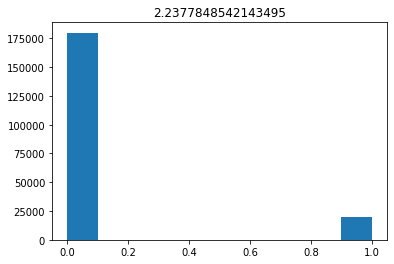

In [10]:
plt.hist(Y)
plt.title(len(yh)/len(yf))

# Separating in Train, Val and Test data

In [11]:
x_train,x_test,y_train,y_test = train_test_split(x_used,y_used,test_size=0.3,random_state = 30)
x_val,x_test,y_val,y_test = train_test_split(x_test,y_test,test_size=0.5,random_state = 30)

In [12]:
x_data = [x_train,x_val,x_test]
y_data = [y_train,y_val,y_test]

### Verifying the size of each dataframe

In [13]:
print('Size of Train Data: {0}, not anomalys/anomaly:{1}'.format(len(x_data[0]),Counter(y_data[0])))
print('Size of val Data: {0}, not anomalys/anomaly:{1}'.format(len(x_data[1]),Counter(y_data[1])))
print('Size of test Data: {0}, not anomalys/anomaly:{1}'.format(len(x_data[2]),Counter(y_data[2])))

Size of Train Data: 45551, not anomalys/anomaly:Counter({0: 31412, 1: 14139})
Size of val Data: 9761, not anomalys/anomaly:Counter({0: 6779, 1: 2982})
Size of test Data: 9761, not anomalys/anomaly:Counter({0: 6784, 1: 2977})


# Importing some metrics to evaluating the models.

In [14]:
def f1Score(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [15]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Here we have 3 differents model, each of them will make a especific work:

- The best non anomaly predictor.
- The best anomaly predictor.
- Balanced predictor.

In [16]:
xgb = XGBClassifier()
xgb.load_model(path+'Undersampling/Boost/models/XGBoostClassifier')

rna = load_model(path+'Undersampling/models/RNA5/RNA5.h5', custom_objects={'f1Score': f1Score})

cat = CatBoostClassifier()
cat.load_model(path+'/Undersampling/Boost/models/CatBoostClassifier')

W1008 19:47:53.462038 140657131022144 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1008 19:47:53.463912 140657131022144 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1008 19:47:53.481639 140657131022144 deprecation.py:506] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W1008 19:47:53.638101 140657131022144 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/optimizers.py:790: The name tf.tra

In [17]:
rna.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total para

# Making Predictions

In [18]:
new_data = [np.vstack((cat.predict_proba(x_data[0])[:,1],xgb.predict_proba(x_data[0])[:,1],np.ravel(rna.predict(x_data[0])),y_data[0])).T,
         np.vstack((cat.predict_proba(x_data[1])[:,1],xgb.predict_proba(x_data[1])[:,1],np.ravel(rna.predict(x_data[1])),y_data[1])).T,
         np.vstack((cat.predict_proba(x_data[2])[:,1],xgb.predict_proba(x_data[2])[:,1],np.ravel(rna.predict(x_data[2])),y_data[2])).T] 

In [19]:
for i in range(len(new_data)):
    new_data[i] = pd.DataFrame(new_data[i],columns=['cat','xgb','rna','target'])
    average = pd.DataFrame(new_data[i].iloc[:,[0,1,2]].mean(axis = 1, skipna = True),columns=['mean'])
    new_data[i] = new_data[i].join(average.reset_index(drop=True))
    geo_mean = pd.DataFrame(np.sqrt(new_data[i].iloc[:,[0,1,2]].prod(axis = 1, skipna = True))/
                           new_data[i].iloc[:,[0,1,2]].sum(axis = 1, skipna = True),columns=['geo_mean'])
    new_data[i] = new_data[i].join(geo_mean.reset_index(drop=True))
    new_data[i] = new_data[i][['cat','xgb','rna','geo_mean','mean','target']]


In [20]:
new_data[0].head()

,cat,xgb,rna,geo_mean,mean,target
0,0.031772,0.657060,0.058842,0.046877,0.249225,0.0
1,0.029919,0.633083,0.126966,0.062078,0.263323,0.0
2,0.507097,0.687710,0.253116,0.205193,0.482641,1.0
3,0.980173,0.933945,0.885128,0.321569,0.933082,1.0
4,0.094978,0.653517,0.085252,0.087249,0.277916,0.0


# Inputing the new data in Combiner Algorithm

In [23]:
K.clear_session()

model = models.Sequential()
model.add(layers.Dense(units = 3, activation='tanh',input_shape = (5,)))
model.add(layers.Dense(units = 1,activation = 'sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 18        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4         
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________


In [24]:
mom = optimizers.SGD(lr=0.0001, decay=0, momentum=0.9, nesterov=True)
model.compile(loss = 'binary_crossentropy',metrics=[f1Score],optimizer = mom)
history = model.fit(new_data[0].loc[:,'cat':'mean'],new_data[0]['target'],epochs = 50,batch_size=32, 
                     validation_data =(new_data[1].loc[:,'cat':'mean'],new_data[1]['target']))

Train on 45551 samples, validate on 9761 samples
Epoch 1/50
45551/45551 [==============================] - 1s 30us/step - loss: 0.6693 - f1Score: 0.1188 - val_loss: 0.6122 - val_f1Score: 0.0000e+00
Epoch 2/50
45551/45551 [==============================] - 1s 26us/step - loss: 0.5900 - f1Score: 0.0000e+00 - val_loss: 0.5716 - val_f1Score: 0.0000e+00
Epoch 3/50
45551/45551 [==============================] - 1s 27us/step - loss: 0.5551 - f1Score: 0.0000e+00 - val_loss: 0.5450 - val_f1Score: 0.0000e+00
Epoch 4/50
45551/45551 [==============================] - 1s 27us/step - loss: 0.5265 - f1Score: 0.0063 - val_loss: 0.5215 - val_f1Score: 0.0533
Epoch 5/50
45551/45551 [==============================] - 1s 27us/step - loss: 0.4997 - f1Score: 0.2785 - val_loss: 0.4996 - val_f1Score: 0.3955
Epoch 6/50
45551/45551 [==============================] - 1s 31us/step - loss: 0.4744 - f1Score: 0.5199 - val_loss: 0.4797 - val_f1Score: 0.5364
Epoch 7/50
45551/45551 [==============================] - 1s 

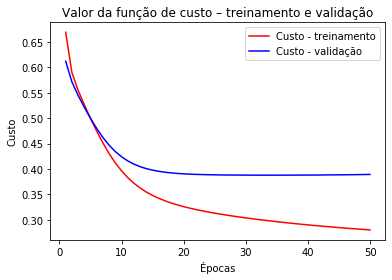

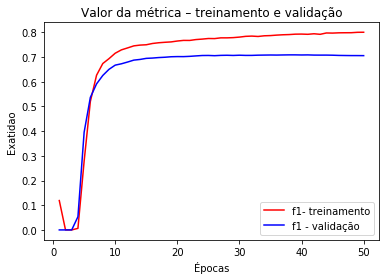

In [25]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1Score']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1Score']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

# Choosing the threshold that maximize the F1score

In [26]:
def choosing_threshold(y_true,y_prob,threshold_list):
    y_hat = []
    precision = []
    recall = []
    f1 = []
    y_h = []
    for threshold in threshold_list:
        for i in range(len(y_true)):
            if y_prob[i]>threshold:
                y_hat.append(1)
            else:
                y_hat.append(0)
        precision.append(precision_score(y_true,y_hat))
        recall.append(recall_score(y_true,y_hat))
        f1.append(f1_score(y_true,y_hat))
        y_h.append(y_hat)
        y_hat = []
    return(precision,recall,f1,y_h)                       

In [27]:
precision,recall,f1,yprob = choosing_threshold(new_data[1]['target'],
                                               model.predict(new_data[1].loc[:,'cat':'rna'])
                                                              ,np.arange(0,1,0.01))

ValueError: Error when checking input: expected dense_1_input to have shape (5,) but got array with shape (3,)

In [ ]:
max(f1)

In [ ]:
for i in range(len(yprob)):
    plot_confusion_matrix(new_data[1]['target'].astype(int), yprob[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)